# Assignment 7

# 1 Cosmology with Supernovae Ia

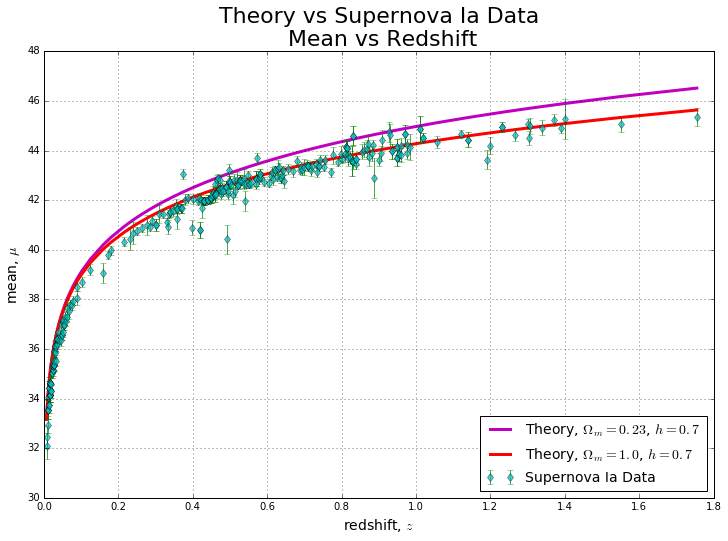

In [1]:
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import emcee # for problem 4


%matplotlib inline

z_data = np.genfromtxt('SN.dat', skip_header=1, usecols=(1))
mu_data = np.genfromtxt('SN.dat', skip_header=1, usecols=(2))
err_data = np.genfromtxt('SN.dat', skip_header=1, usecols=(3))


# copies of data placed in numpy arrays for sorting
z = np.array(z_data)
mu = np.array(mu_data)
err = np.array(err_data)


z.sort()
for i in range(len(z)):
    for j in range(len(z)):
        if z_data[j] == z[i]:
            mu[i] = mu_data[j]
            err[i] = err_data[j]

OmegaM0 = 0.23
OmegaM1 = 1.0
h0 = 0.7
steps = len(z) # number of data points

# initial parameters for question 3
params0 = [h0, OmegaM0]
params1 = [h0, OmegaM1]

###### FUNCTIONS ######

# integrand to calculate D_c
def f(z, params):
    h, OmegaM = params # this line is needed in all functions
    OmegaL = 1.0-OmegaM # don't do this outside the function since you have multiple OmegaM's
    f = (3000.0/h)/(np.sqrt(OmegaM*np.power((1.0+z),3.0)+OmegaL)) # this is the entire integrand
    return f

# integrating to get D_c
def Dc(z, params):
    h, OmegaM = params
    Dc = [] # define this inside the function so that everytime the code is run a new Dc is created
    f_int = lambda z: f(z, params) # integrating f with respect to z
    for i in range(steps): # for loop over all data points
        intEz = integrate.quad(f_int,0.0,z[i]) # this integrates from 0 to z[i]
        Dc.append(intEz[0]) # then that value is appended to the array Dc
    return Dc

# D*_L function, h has been factored out!!!
def DL(z, params):
    h, OmegaM = params
    DL = (1.0+z)*Dc(z, params) # no h!
    return DL


# mu function
def MU(z, params):
    h, OmegaM = params
    MU = [] # again, define this inside the function so a new one is created each time
    MU = 25.0 - 5.0*np.log10(h) + 5.0*np.log10(DL(z, params))
    return MU

# plotting theory verses data
plt.figure(figsize=(12,8))
plt.plot(z, MU(z, params0), 'm', linewidth=3, label='Theory, $\Omega_{m} = 0.23$, $h = 0.7$')
plt.plot(z, MU(z, params1), 'r', linewidth=3, label='Theory, $\Omega_{m} = 1.0$, $h = 0.7$')
plt.errorbar(z, mu, yerr=err, fmt='cd', ecolor='g', alpha=0.7, label='Supernova Ia Data')
plt.legend(fontsize=14, loc=4)
plt.grid(True)
plt.xlabel('redshift, $z$',fontsize=14)
plt.ylabel('mean, $\mu$',fontsize=14)
plt.title('Theory vs Supernova Ia Data\n Mean vs Redshift',fontsize=22)
plt.show()

# 2 DATA 

(a) The 'Mean vs Redshift' plot above looks very similar to figure (6) from Riess et al.

(b) There's definitely a difference. $\Omega_{m} = 1.0\ $ seems to fit the data much better than $\Omega_{m} = 0.23\ $.

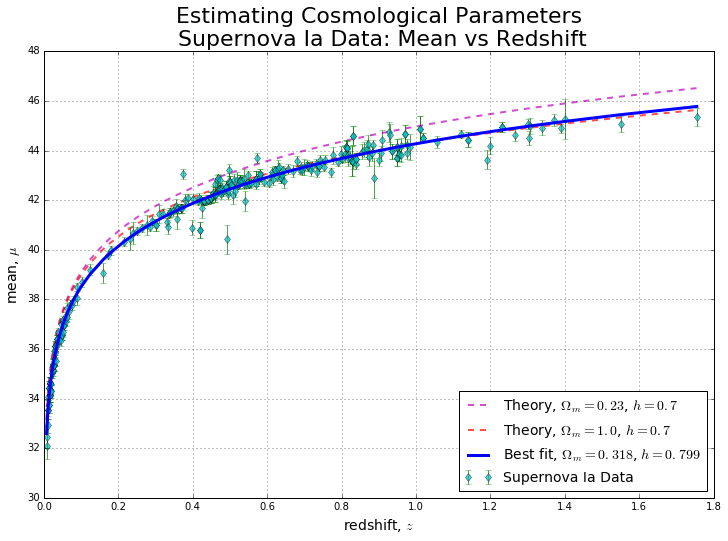

Theory when h = 0.7
Chisquared for Omega_m = 0.23: 11.1700691132 - not a good fit
Chisquared for Omega_m = 1.0: 0.673360096309 - over-fit

Best fit Chisquared (leastsq): 1.49795245408 - good fit, close to 1
Where, h = 0.799218133862 and Omega_m = 0.317969153317


In [3]:
# Chisquared
def chi2(params, args=(z,mu,err)): # args=z also works just fine since mu and err are globally defined and don't change
    h, OmegaM = params
    MU0 = MU(z, params) # must create MU array inside this function
    for i in range(steps):
        chi2 = 0.0
        chi2 += np.power((mu[i]-MU0[i]),2.0)/np.power(err[i],2.0) 
    return chi2

# fmin on chisquared
#xopt = optimize.fmin(chi2, params0)


# using leastsq to find best fit line and cosmological parameters
fitfunc = lambda params, z: MU(z, params) # Target function
errfunc = lambda params, z, y: fitfunc(params, z) - y # Distance to the target function
p0 = params1 # Initial guess for the parameters, could also use params0 as it is a good enough guess
p1, success = optimize.leastsq(errfunc, p0[:], args=(z, mu)) # p1 is the best fit parameters

# question 3 plot
plt.figure(figsize=(12,8))
plt.plot(z, MU(z, params0), 'm--', linewidth=2, alpha=0.7, label='Theory, $\Omega_{m} = 0.23$, $h = 0.7$')
plt.plot(z, MU(z, params1), 'r--', linewidth=2, alpha=0.7, label='Theory, $\Omega_{m} = 1.0$, $h = 0.7$')
plt.errorbar(z, mu, yerr=err, fmt='cd', ecolor='g', alpha=0.7, label='Supernova Ia Data')
plt.plot(z, MU(z, p1), 'b', linewidth=3, label='Best fit, $\Omega_{m} = 0.318$, $h = 0.799$')
plt.legend(fontsize=14, loc=4)
plt.grid(True)
plt.xlabel('redshift, $z$',fontsize=14)
plt.ylabel('mean, $\mu$',fontsize=14)
plt.title('Estimating Cosmological Parameters\n Supernova Ia Data: Mean vs Redshift',fontsize=22)
plt.show()

# printing chisquared results
print "Theory when h = 0.7"
print "Chisquared for Omega_m = 0.23: "+str(chi2(params0, args=(z,mu,err))) + ' - not a good fit'
print "Chisquared for Omega_m = 1.0: "+str(chi2(params1, args=(z,mu,err))) + ' - over-fit'

'''
Minimizing chi2 doesn't make sense, so I'm not using those parameter, they give a chi2 value close to 0 which is over-fitting.
'''
#print "\nBest fit Chisquared (fmin): "+str(chi2(xopt, args=(z,mu,err)))
#print 'Where, h = ' +str(xopt[0]) + ' and Omega_m = ' +str(xopt[1])

print "\nBest fit Chisquared (leastsq): "+str(chi2(p1, args=(z,mu,err))) + ' - good fit, close to 1'
print 'Where, h = ' +str(p1[0]) + ' and Omega_m = ' +str(p1[1])

# 3 Estimating parameters

I used scipy.optimize.leastsq to find a best fit line and it's parameters.

This best fit line can be seen in the plot above, and it is definitely a better fit than the other parameters.

To varify this we compare chi squared values. Our best fit line gives a chi squared of 1.5, which is very good,
when compared to the other fit lines plotted in problem 2.

The closer the chi suared value is to 1 the better the fit, if it is less than 1 than it is over-fit.